Fully Connected (Dense) Variational Autoencoder 

Authored by David Luong

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
#import graphviz # for showing model diagram
#print('graphviz: %s' % graphviz.__version__) # print version
#import plotly
#import plotly.express as px # for data visualization
#print('plotly: %s' % plotly.__version__) # print version

# Other utilities
import sys
import os
import json
import random
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
matplotlib: 3.5.0


Define Run Settings

In [2]:
# parameters
real_malware = 'WinWebSec' # OnLineGames, Renos, VBInject, WinWebSec, Zbot

use_harshit = 0 # 1 to use Harshit's fake samples, other to use Albert's
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts
latent_dim = 2 # latent space dimension
number_files = 10
# Specify dimensions for input/output and latent space layers
max_sequence_length = 600 # number of opcodes at the input layer (same as maximum length sequence)

num_epochs = 200
num_batch_size = 16

if real_malware == 'WinWebSec':
    fake_malware = 'wws'
    savedir_malware = 'wws'
elif real_malware == 'OnLineGames':
    fake_malware = 'olgames'
    savedir_malware = 'olgames'
elif real_malware == 'Renos':
    fake_malware = 'renos'
    savedir_malware = 'renos'
elif real_malware == 'VBInject':
    fake_malware = 'vbinject'
    savedir_malware = 'vbinject'
elif real_malware == 'Zbot':
    fake_malware = 'zbot'
    savedir_malware = 'zbot'
else:
    print('!!!Malware not found!!!')

Define Helper Functions

In [3]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

Load Real Malware Files

In [4]:
# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# opening list of unique opcodes
if unique_opcodes == 0:
    my_fp = './code/visualize_explore/opcodes/'
    my_opcodes = open(my_fp + 'opcodes' + real_malware + '.txt','r')
    opcodes = my_opcodes.read()
    opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
    opcodes_into_list.remove('')
    # close opcodes file
    my_opcodes.close()
elif unique_opcodes == 1:
    my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
    opcodes_into_list = get_opcode_dict(real_malware,my_fp)

# real malware parameters
my_filepath = "../malware_data/" + real_malware +'/'
dir_list = os.listdir(my_filepath)

# process real malware
for fm in dir_list:
    # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
    print('Processing real malware' + my_filepath + fm)

    # opening the file in read mode
    my_file = open(my_filepath + fm, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")
    
    # remove '' from opcodes
    data_into_list.remove('')
    
    opcode_frequency = []
    if data_into_list:
            
        # create (opcode frequency, rank) tuple
        idx = 0
        for x in opcodes_into_list:
            count = countX(data_into_list, x)
            #print('{} has occurred {} times'.format(x,count))
            opcode_frequency.append((count,idx))
            idx+=1
        # print(sorted(opcode_frequency,reverse=True))

        # opcodes are indexed by overall frequency
        opcode_frequency = get_opcode_freq(opcode_frequency)

        # opcodes are indexed by opcodes_into_list position
        opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

        # add real malware to dataset
        dataset.append(opcode_position)
        dataset_names.append(fm)
        dataset_ind.append(0) # 0 is indicator for real malware
    else:
        # skip processing if malware file is empty
        print('------------> is empty ... skipping')

    # close file
    my_file.close()

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

Processing real malware../malware_data/WinWebSec/0009d99691e8eed99c7dd1500e07cda336d54260.asm.txt
Processing real malware../malware_data/WinWebSec/00113d9802cca3deba19cf9daa17f1c2269de2b8.asm.txt
Processing real malware../malware_data/WinWebSec/0036d720d8ff6c8f4860b5c69deba7c400e4d356.asm.txt
Processing real malware../malware_data/WinWebSec/0037c7716f1dc8e5c4e1f9a9f3e9d5aedb7a6979.asm.txt
Processing real malware../malware_data/WinWebSec/003824de7a82d2db9fc877c44ea93f76dd0e5ca9.asm.txt
Processing real malware../malware_data/WinWebSec/00427746e03afb4d3b28791a82315e52acf66a0b.asm.txt
Processing real malware../malware_data/WinWebSec/004bb59ba37917bfea49e6904f0551df7b3c719f.asm.txt
Processing real malware../malware_data/WinWebSec/005150c72b9cd08a62bc0d730e3593b4f160534a.asm.txt
Processing real malware../malware_data/WinWebSec/005231177f706856a0617a2c871d627ddedf54a7.asm.txt
Processing real malware../malware_data/WinWebSec/005e219370aaf892509b509b76cb082b36b16fcf.asm.txt
There are 10 malware

Define Training and Testing Datasets

In [5]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
X_train_reshaped = X_train.reshape(sample_size, time_steps)*norm_factor
np.shape(X_train_reshaped)

sample_size = X_test.shape[0]
time_steps = X_test.shape[1]
X_test_reshaped = X_test.reshape(sample_size, time_steps)*norm_factor
np.shape(X_test_reshaped)

print(len(opcodes_into_list))
print(X_train_reshaped)

21
[[0.         0.         0.         ... 0.5        0.04545455 0.54545455]
 [0.18181818 0.18181818 0.18181818 ... 0.40909091 0.36363636 0.36363636]
 [0.         0.         0.         ... 0.         0.18181818 0.54545455]
 [0.         0.         0.40909091 ... 0.40909091 0.36363636 0.36363636]
 [0.40909091 0.04545455 0.04545455 ... 0.18181818 0.18181818 0.54545455]
 [0.09090909 0.31818182 0.27272727 ... 0.40909091 0.36363636 0.36363636]]


In [6]:
#--- Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

Define Encoder

In [7]:
# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(max_sequence_length,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
encoder.summary()
#plot_model(encoder, show_shapes=True, dpi=300)

Model: "Encoder-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input-Layer (InputLaye  [(None, 600)]       0           []                               
 r)                                                                                               
                                                                                                  
 Encoder-Hidden-Layer-1 (Dense)  (None, 64)          38464       ['Encoder-Input-Layer[0][0]']    
                                                                                                  
 Encoder-Hidden-Layer-2 (Dense)  (None, 16)          1040        ['Encoder-Hidden-Layer-1[0][0]'] 
                                                                                                  
 Encoder-Hidden-Layer-3 (Dense)  (None, 8)           136         ['Encoder-Hidden-Laye

Define Decoder

In [8]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(max_sequence_length, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
decoder.summary()
#plot_model(decoder, show_shapes=True, dpi=300)

Model: "Decoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Z-Sampling (InputLaye  [(None, 2)]              0         
 r)                                                              
                                                                 
 Decoder-Hidden-Layer-1 (Den  (None, 8)                24        
 se)                                                             
                                                                 
 Decoder-Hidden-Layer-2 (Den  (None, 16)               144       
 se)                                                             
                                                                 
 Decoder-Hidden-Layer-3 (Den  (None, 64)               1088      
 se)                                                             
                                                                 
 Decoder-Output-Layer (Dense  (None, 600)            

Define VAE Model

In [9]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

Define VAE Loss Function

In [10]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = max_sequence_length * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Train the VAE and Plot Loss Function

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 98.8975 - val_loss: 104.6811
Epoch 2/200
1/1 [==============================] - 0s 51ms/step - loss: 98.5648 - val_loss: 104.0335
Epoch 3/200
1/1 [==============================] - 0s 60ms/step - loss: 98.3352 - val_loss: 104.1507
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 98.1013 - val_loss: 103.9828
Epoch 5/200
1/1 [==============================] - 0s 58ms/step - loss: 97.3232 - val_loss: 103.5386
Epoch 6/200
1/1 [==============================] - 0s 59ms/step - loss: 97.1950 - val_loss: 102.5933
Epoch 7/200
1/1 [==============================] - 0s 63ms/step - loss: 97.2144 - val_loss: 102.6189
Epoch 8/200
1/1 [==============================] - 0s 64ms/step - loss: 96.8403 - val_loss: 101.9286
Epoch 9/200
1/1 [==============================] - 0s 61ms/step - loss: 97.2964 - val_loss: 101.8340
Epoch 10/200
1/1 [==============================] - 0s 58ms/step - loss: 96.3771 - val_loss: 

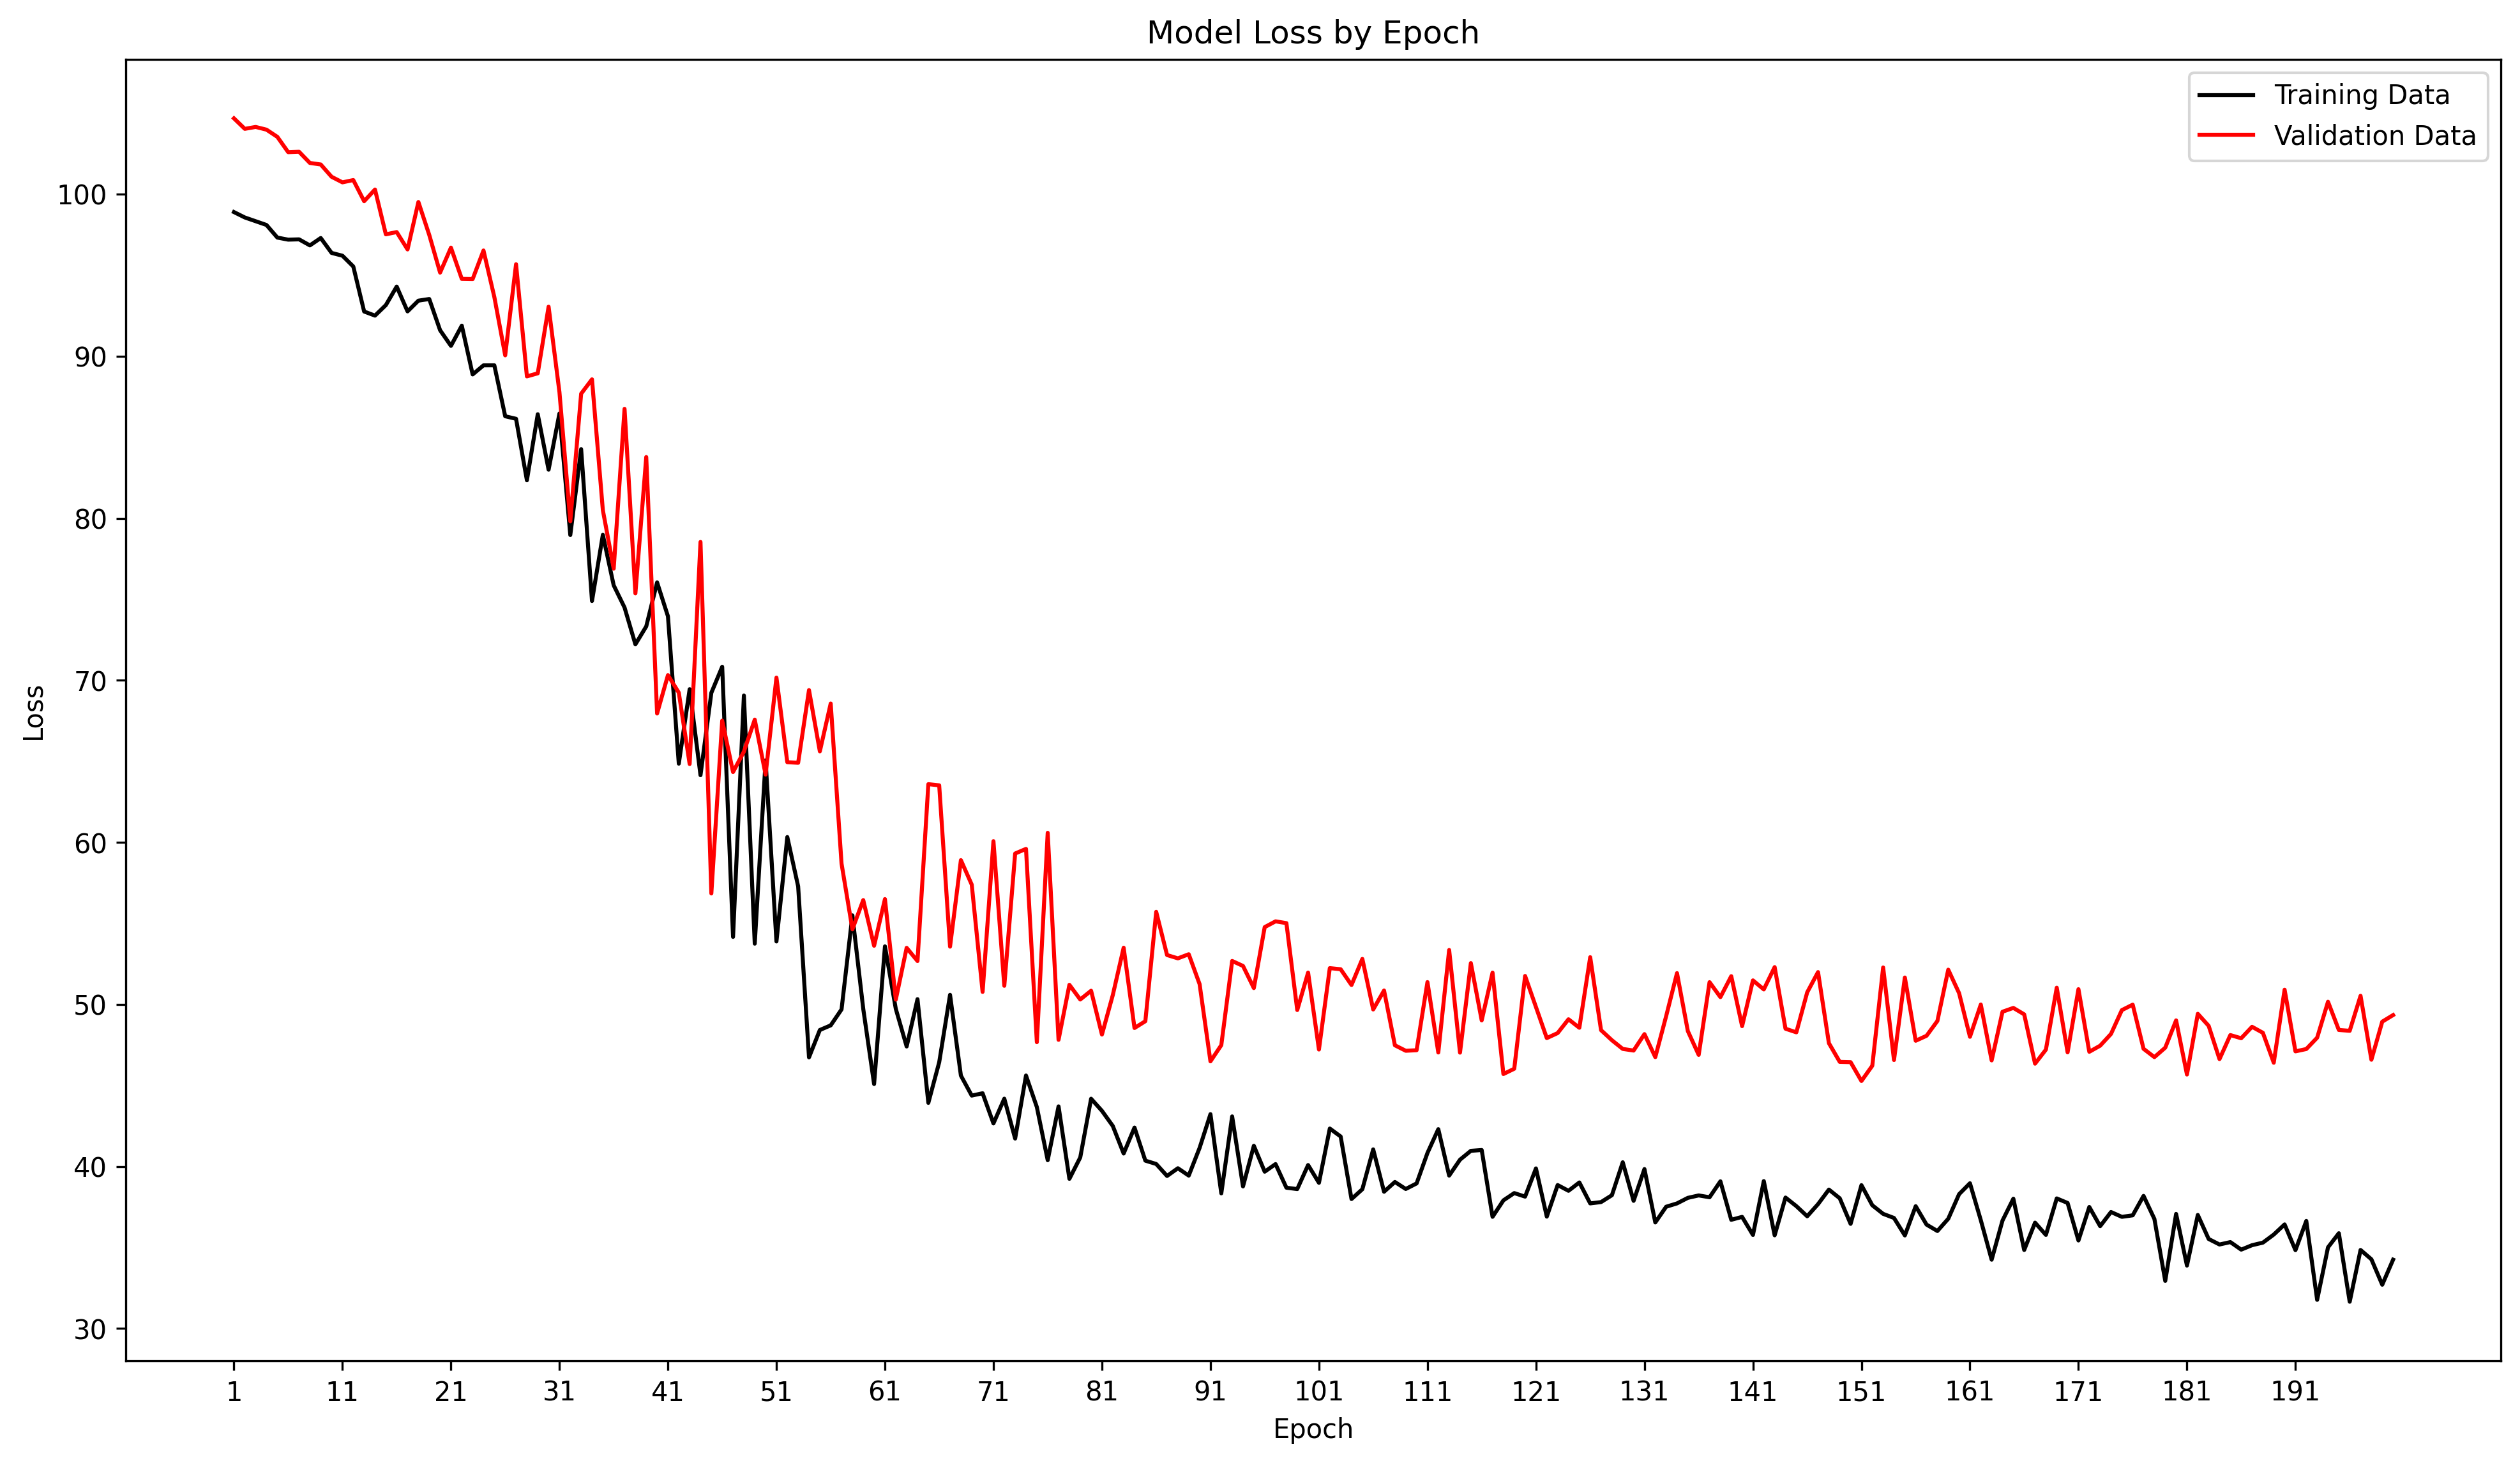

In [11]:
# Train VAE model
history = vae.fit(X_train_reshaped, y_train, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test_reshaped, y_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Validation Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=10), labels=np.arange(1, len(history.history['loss'])+1, step=10))
plt.legend()
plt.show()

Visualize the Latent Space

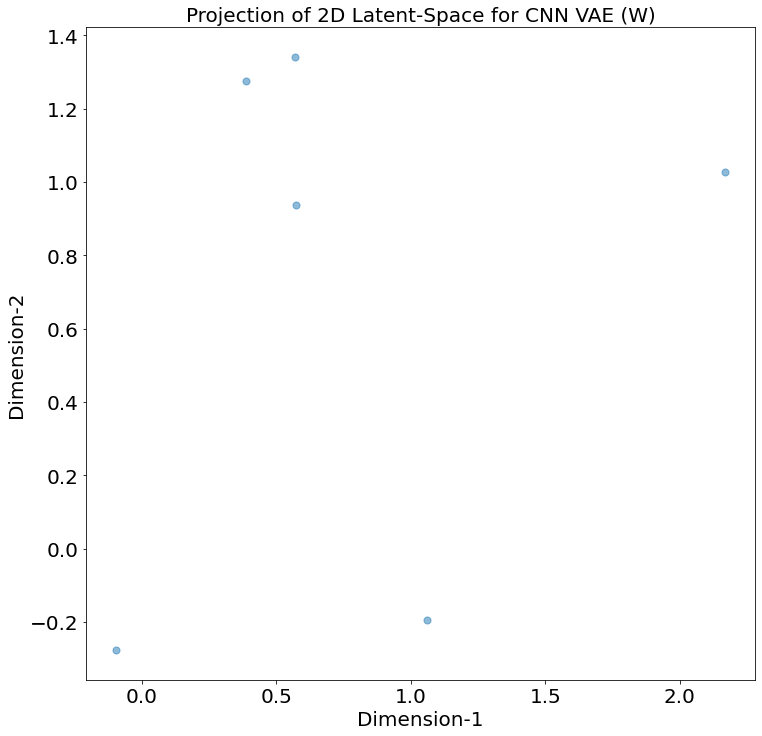

In [12]:
a,b,c = encoder.predict(X_train_reshaped)
embeddings = sampling([a, b])

figsize = 12
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=50)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space for CNN VAE (" + real_malware[0] +")", size=20)
plt.show()

[Disabled] Another Way to Visualize Latent Space

In [13]:
# Use encoder model to encode inputs into a latent space
#X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
#fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
#                 opacity=1, color=y_test.astype(str))

# Change chart background color
#fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
#fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
#                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
#                 showline=True, linewidth=1, linecolor='white',
#                 title_font=dict(size=10), tickfont=dict(size=10))
#
#fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
#                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
#                 showline=True, linewidth=1, linecolor='white',
#                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
#fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
#fig.update_traces(marker=dict(size=2))

#fig.show()

Generate Fake Malware

[0.35823605883723475, 0.3986827319041123]


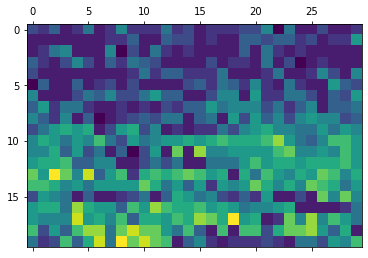

[0.6078164311353473, 0.6618894360320847]


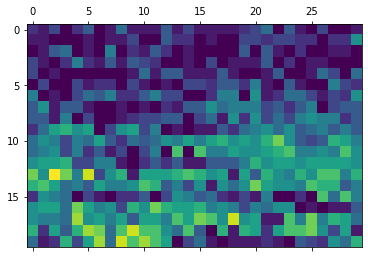

[0.4257884255260146, 0.30886515603175413]


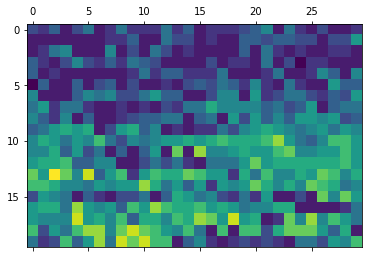

[0.08514582245061408, 0.5040006028242369]


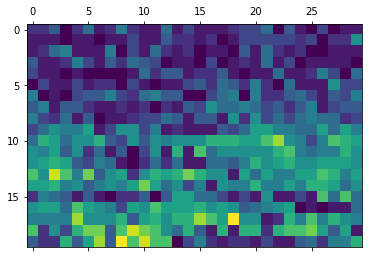

[0.5365094126895394, 0.3934593396265009]


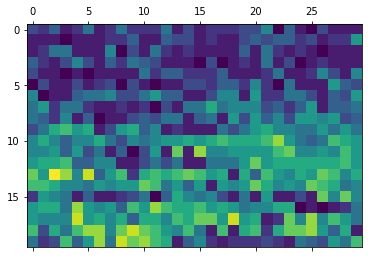

[0.5479532515922914, 0.3405808156011352]


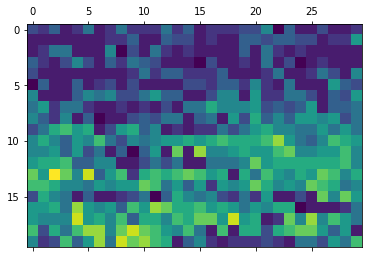

[0.7695561675563715, 0.5216343034003464]


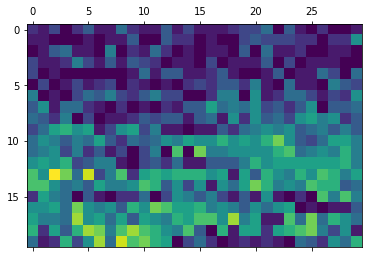

[0.7666971115025535, 0.15169169369337343]


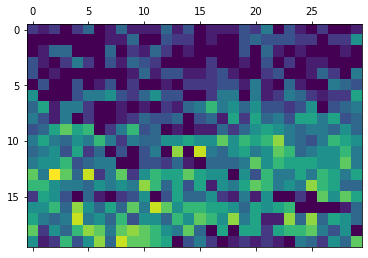

[0.07971263389841898, 0.5014550083095575]


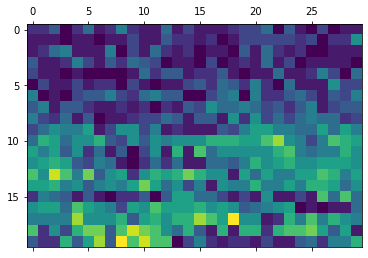

[0.38125440439216185, 0.31856423641660603]


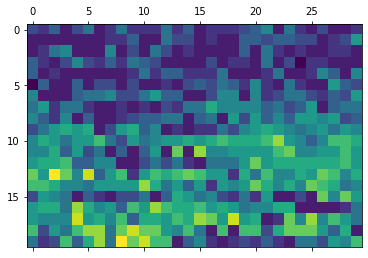

In [15]:
# Input latent space coordinates

for nF in range(number_files):
    randomlist = []
    for i in range(0,latent_dim):
        #n = random.randint(0,len(opcodes_into_list))
        #n = (random.random() - 0.5)*2
        n = random.random()
        randomlist.append(n)
    print(randomlist)
    z_sample_opcode=[randomlist]

    # Decode latent inputs (i.e., generate new outputs)
    opcode_decoded = decoder.predict(z_sample_opcode)

    tmp = np.rint(opcode_decoded.reshape(20,30)*len(opcodes_into_list)).astype(int)

    # Reshape and display the image
    plt.matshow(tmp)
    plt.show()

    # map output back to opcodes and write
    my_fp = './code/fake_tests/vae_dense_samples/'
    my_opcodes = open(my_fp + fake_malware + '/' + 'generated_' + real_malware + '_' + str(nF+1) + '.txt','a+')

    for row in tmp:
        for col in row:
            my_opcodes.write(opcodes_into_list[col])
            my_opcodes.write('\n')
    # close opcodes file
    my_opcodes.close()